Bienvenido a la segunda parte del proyecto, en este caso opte por realizar esta parte del proyecto con Google Colab para cuidar el CPU de mi computadora y aprovechar al maximo el GPU que me proporciona Colab.

Descargamos el set de datos

In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O cats_and_dogs_filtered.zip

!unzip -q cats_and_dogs_filtered.zip

--2024-07-23 01:28:05--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  18.9MB/s    in 4.4s    

2024-07-23 01:28:12 (14.9 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
#obtenemos las rutas de las imagenes de entrenamiento y validación
train_dir = "cats_and_dogs_filtered/train"
valid_dir = "cats_and_dogs_filtered/validation"

In [3]:
#Importamos ImageDataGenerator para poder tomar las imagenes y aplicarle varios filtros
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
#realizamos un reescalado para las imagenes de entrenamiento y validación
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
#Marcamos la ruta de las imagenes, el tipo de formato que las queremos, los lotes y el tipo de etiquetas
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Una vez terminado la parte de normalizar las imagenes pasaremos a la importacion del modelo VGG16 y ResNet50.

In [6]:
#Importamos VGG16 y ResNet50
from tensorflow.keras.applications import VGG16, ResNet50

In [7]:
#Cargaremos los modelos sin las capaz

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 6s 0us/step


In [8]:
#Congelamos el modelo

vgg16.trainable = False
resnet50.trainable = False

In [9]:
#Importamos Squential para crear nuestra red neuronal y creamos nuestros modelos

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [11]:
# Creamos nuestra red con la ultima capa modificada

# Añadimos nuevas capas de clasificación
x = vgg16.output
x = GlobalAveragePooling2D()(x)  # Reducimos la dimensionalidad del tensor
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Salida binaria

# Creamos el modelo final
model_vgg = Model(inputs=vgg16.input, outputs=predictions)

#Ahora hacemos lo mismo con resnet50
x = resnet50.output
x = GlobalAveragePooling2D()(x)  # Reducimos la dimensionalidad del tensor
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Salida binaria

# Creamos el modelo final
model_resnet50 = Model(inputs=resnet50.input, outputs=predictions)

In [12]:
#Obtenemos el resumen de los modelos
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [13]:
model_resnet50.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [14]:
#Copilamos los modelos

model_vgg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_resnet50.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
#Entrenamos los modelos

history_vgg = model_vgg.fit(train_generator, steps_per_epoch=100, epochs=10, validation_data=valid_generator, validation_steps=50)

Epoch 1/10
100/100 [==============================] - 24s 157ms/step - loss: 0.4322 - accuracy: 0.8005 - val_loss: 0.2857 - val_accuracy: 0.8900
Epoch 2/10
100/100 [==============================] - 15s 154ms/step - loss: 0.2685 - accuracy: 0.8910 - val_loss: 0.2554 - val_accuracy: 0.8870
Epoch 3/10
100/100 [==============================] - 15s 154ms/step - loss: 0.2229 - accuracy: 0.9075 - val_loss: 0.2369 - val_accuracy: 0.8990
Epoch 4/10
100/100 [==============================] - 15s 152ms/step - loss: 0.2109 - accuracy: 0.9070 - val_loss: 0.2551 - val_accuracy: 0.8830
Epoch 5/10
100/100 [==============================] - 15s 151ms/step - loss: 0.1908 - accuracy: 0.9230 - val_loss: 0.2050 - val_accuracy: 0.9170
Epoch 6/10
100/100 [==============================] - 15s 153ms/step - loss: 0.1665 - accuracy: 0.9375 - val_loss: 0.2370 - val_accuracy: 0.8980
Epoch 7/10
100/100 [==============================] - 15s 153ms/step - loss: 0.1960 - accuracy: 0.9100 - val_loss: 0.1995 - val_ac

In [16]:
history_resnet50 = model_resnet50.fit(train_generator, steps_per_epoch=100, epochs=10, validation_data=valid_generator, validation_steps=50)

Epoch 1/10
100/100 [==============================] - 19s 135ms/step - loss: 0.7832 - accuracy: 0.5310 - val_loss: 0.8473 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 13s 125ms/step - loss: 0.7020 - accuracy: 0.5725 - val_loss: 0.6427 - val_accuracy: 0.6300
Epoch 3/10
100/100 [==============================] - 11s 110ms/step - loss: 0.6505 - accuracy: 0.6260 - val_loss: 0.6429 - val_accuracy: 0.6180
Epoch 4/10
100/100 [==============================] - 11s 111ms/step - loss: 0.6461 - accuracy: 0.6300 - val_loss: 0.6473 - val_accuracy: 0.6060
Epoch 5/10
100/100 [==============================] - 11s 110ms/step - loss: 0.6417 - accuracy: 0.6260 - val_loss: 0.6334 - val_accuracy: 0.6420
Epoch 6/10
100/100 [==============================] - 11s 110ms/step - loss: 0.6446 - accuracy: 0.6345 - val_loss: 0.7072 - val_accuracy: 0.5540
Epoch 7/10
100/100 [==============================] - 13s 125ms/step - loss: 0.6468 - accuracy: 0.6280 - val_loss: 0.6312 - val_ac

Veamos en un grafico de linea

In [61]:
#Importamos las librerias
import seaborn as sns
import matplotlib.pyplot as plt

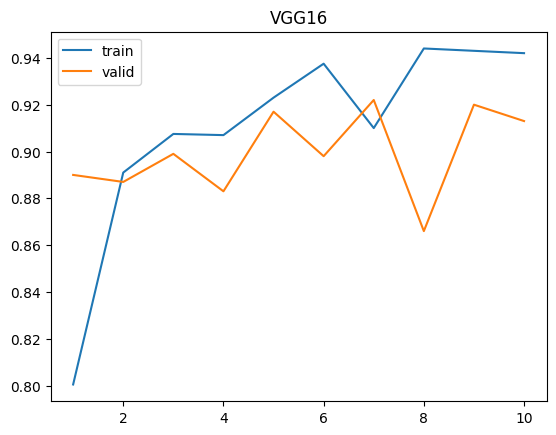

In [62]:
epoch_count = range(1,11)
plt.title('VGG16')
sns.lineplot(x=epoch_count,  y=history_vgg.history['accuracy'], label='train',)
sns.lineplot(x=epoch_count,  y=history_vgg.history['val_accuracy'], label='valid')
plt.show()

In [ ]:
#realizamos lo mismo con resnet50
plt.title('Resnet50')
sns.lineplot(x=epoch_count,  y=history_resnet50.history['accuracy'], label='train',)
sns.lineplot(x=epoch_count,  y=history_resnet50.history['val_accuracy'], label='valid')
plt.show()

Vemos que vgg16 obtuvo un mejor puntaje y un mejor puntaje de validacion, pero veamos que tal les va realizandoles una prueba.

Subire los archivos a la carpeta test pero mientras realice la normalizacion me percate que se habia generado una carpeta oculpa, lo cual procedí a borrar

In [43]:
#Observamos las carpetas y archivos
import os
for root, dirs, files in os.walk(test_dir):
    print("Root:", root)
    print("Dirs:", dirs)
    print("Files:", files)

Root: test
Dirs: ['dog', 'cat']
Files: []
Root: test/dog
Dirs: []
Files: ['dog2.jpg', 'dog3.jpg', 'dog4.jpg', 'dog1.jpg', 'dog5.jpg']
Root: test/cat
Dirs: []
Files: ['cat3.jpg', 'cat2.jpg', 'cat5.jpg', 'cat1.jpg', 'cat4.jpg']


In [ ]:
import shutil

# Eliminamos la carpeta .ipynb_checkpoints
checkpoint_dir = os.path.join(test_dir, '.ipynb_checkpoints')
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)


In [40]:
#Tomamos la direccion de la carpeta test la cual tiene imagenes de prueba
test_dir = "cats_and_dogs_filtered/test"

In [41]:
#Realizamos el escalado
test_datagen = ImageDataGenerator(rescale=1./255)

In [42]:
#Marcamos la ruta de las imagenes y las normalizamos
test_gen = test_datagen.flow_from_directory(
        directory=test_dir,
        target_size=(200,200),
        batch_size=1,
        class_mode='binary',
        shuffle=False
)

Found 10 images belonging to 2 classes.


In [45]:
#Realizamos una evaluación de los modelos
model_vgg.evaluate(test_gen, steps=len(test_gen))

10/10 [==============================] - 1s 13ms/step - loss: 0.2315 - accuracy: 0.9000


[0.23147273063659668, 0.8999999761581421]

In [46]:
model_resnet50.evaluate(test_gen, steps=len(test_gen))

10/10 [==============================] - 1s 24ms/step - loss: 1.3994 - accuracy: 0.5000


[1.3994098901748657, 0.5]

Vemos una amplia diferencia entre modelos, realicemos la prediccion y una matriz de confusion.

In [47]:
y_pred_vgg = model_vgg.predict(test_gen, steps=len(test_gen))
y_pred_resnet50 = model_resnet50.predict(test_gen, steps=len(test_gen))

10/10 [==============================] - 1s 14ms/step


In [51]:
import numpy as np

#Normalizamos los resultados obtenidos
y_pred_vgg = np.where(y_pred_vgg > 0.5, 1, 0)
y_pred_resnet50 = np.where(y_pred_resnet50 > 0.5, 1, 0)

In [52]:
#obtenemos las clases
y_test = test_gen.classes

In [53]:
#importamos las herramientas para crear la matriz de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [56]:
#creamos la matriz y la matriz display
cm_vgg = confusion_matrix(y_test,y_pred_vgg)
cmd_vgg = ConfusionMatrixDisplay(cm_vgg)
cm_resnet50 = confusion_matrix(y_test,y_pred_resnet50)
cmd_resnet50 = ConfusionMatrixDisplay(cm_resnet50)

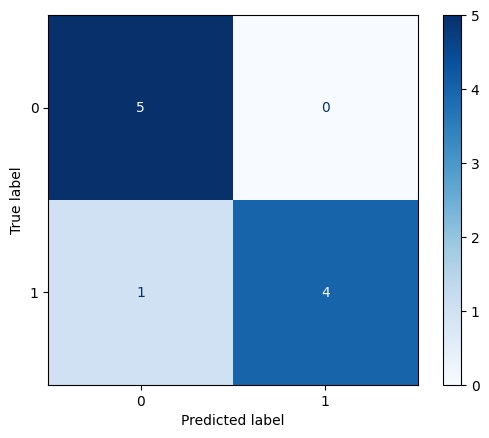

In [59]:
#Ploteamos las matrices
cmd_vgg.plot(cmap='Blues')
plt.show()

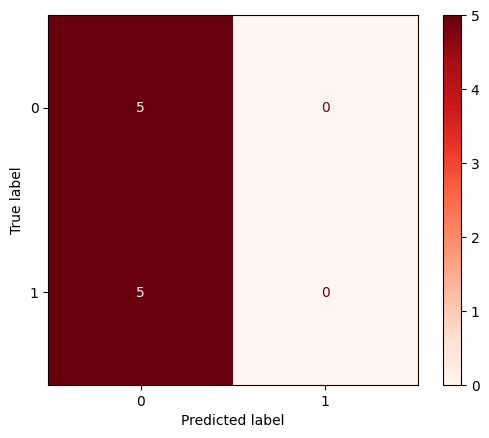

In [60]:
cmd_resnet50.plot(cmap='Reds')
plt.show()

Veamos cada prediccion con su imagen

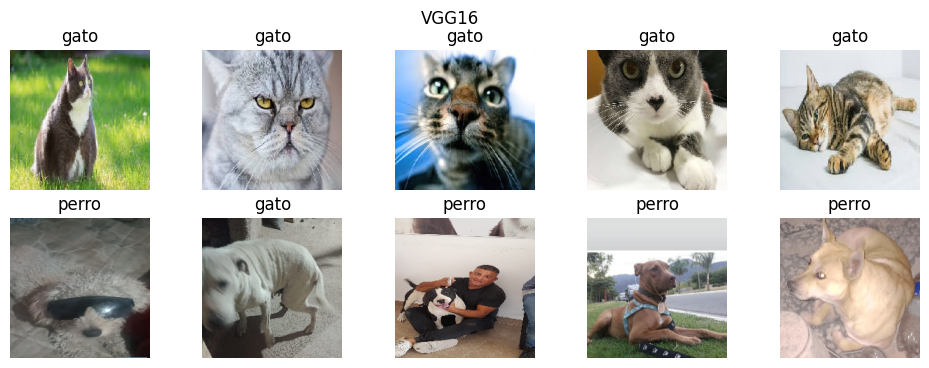

In [63]:
fig = plt.figure(figsize=(12,4))
plt.suptitle('VGG16')
for i in range(len(test_gen)):
    #obtenemos la imagen y clase
    img= test_gen.next()[0]
    clas = y_pred_vgg[i]
    #Normalizamos las clases
    if clas == 0:
        clas = 'gato'
    else:
        clas = 'perro'
    #Comenzamos a crear nuestra imagen
    ax = fig.add_subplot(2,5,i+1)
    ax.imshow(img[0])
    ax.axis('off')
    ax.set_title(clas)
plt.show()

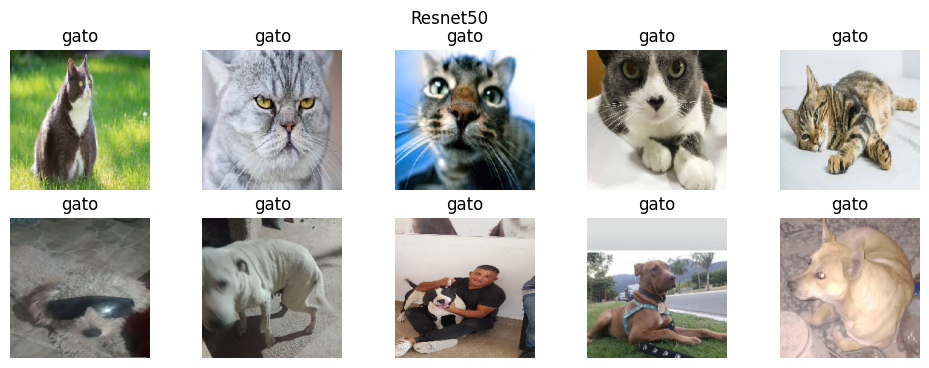

In [64]:
fig = plt.figure(figsize=(12,4))
plt.suptitle('Resnet50')
for i in range(len(test_gen)):
    #obtenemos la imagen y clase
    img= test_gen.next()[0]
    clas = y_pred_resnet50[i]
    #Normalizamos las clases
    if clas == 0:
        clas = 'gato'
    else:
        clas = 'perro'
    #Comenzamos a crear nuestra imagen
    ax = fig.add_subplot(2,5,i+1)
    ax.imshow(img[0])
    ax.axis('off')
    ax.set_title(clas)
plt.show()

¿Podriamos mejorar el Modelo?

Creo que si, podriamos realizar en la seccion de ImageDataGenerator un aumento de datos, tomando las imagenes y realizandoles una serie de cambios para aumentar el set de datos.

Tambien podría realizar una busqueda de mejores modelos para utilizar y aplicar transfer learning.

En a fines de este proyecto, el mismo obtuvo un resultado excelente y ampliamente superior al objetivo establecido.